In [1]:
# Importing all required libraries for the assignment
from pyspark import SparkConf
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
import pandas as pd
import re
import pyspark.sql.functions as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from operator import add

# Part A

# Task 1

## Task 1.1

In [2]:
#Create spark configuration with all threads available on VM and with name as "Assingment-1"
spark_conf = SparkConf().setMaster("local[*]").setAppName("Assignment-1")

In [3]:
#Creating spark context from the configuration
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

In [4]:
#Load the data from all unit.csv files and remove the first row i.e header
unit_rdd = sc.textFile("Data/*Units.csv")
header_unit = unit_rdd.first()
unit_rdd = unit_rdd.filter(lambda row: row != header_unit)
unit_rdd.take(10)

['"2016-1-15/08/2019","01",0,"SA","OMNIBUS","2011","North","Male","056","SA","HR","Full","Not Towing","Straight Ahead","010","5121",,',
 '"2016-1-15/08/2019","02",1,,"Pedestrian on Road",,"East","Male","072",,,,,"Walking on Road",,"5084",,',
 '"2016-2-15/08/2019","01",0,"SA","Motor Cars - Sedan","2004","Unknown","Female","023","SA","C ","Full","Not Towing","Straight Ahead","001","5087",,',
 '"2016-2-15/08/2019","02",0,"SA","Station Wagon","2008","Unknown","Male","040","SA","C ","Full","Not Towing","Straight Ahead","001","5084",,',
 '"2016-3-15/08/2019","01",0,"SA","RIGID TRUCK LGE GE 4.5T","1990","South","Unknown","XXX","SA","MR","Provisional 2","Not Towing","Straight Ahead","001","5115",,',
 '"2016-3-15/08/2019","02",0,"SA","Panel Van","2013","South","Male","023","SA","C ","Full","Not Towing","Straight Ahead","001","5110",,',
 '"2016-4-15/08/2019","01",0,"SA","Station Wagon","2002","East","Female","033","SA","C ","Full","Not Towing","Straight Ahead","001","5169",,',
 '"2016-4-15/08/20

In [5]:
print("Number of record in unit rdd is %d" % (unit_rdd.count()))

Number of record in unit rdd is 153854


In [6]:
#Load the data from all crash.csv files and remove the first row i.e header
crash_rdd = sc.textFile("Data/*Crash.csv")
header_crash = crash_rdd.first()
crash_rdd = crash_rdd.filter(lambda row: row != header_crash)
crash_rdd.take(10)

['"2019-1-8/07/2020","2 Metropolitan","HAMPSTEAD GARDENS","5086","CITY OF PORT ADELAIDE ENFIELD",2,0,0,0,0,2019,"June","Wednesday","11:15 am","060","Cross Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Daylight","Right Angle","01","Driver Rider","1: PDO","Give Way Sign","","",1331810.03,1676603.26,"13318101676603"',
 '"2019-2-8/07/2020","2 Metropolitan","DRY CREEK","5094","CITY OF SALISBURY",2,0,0,0,0,2019,"January","Tuesday","12:49 am","090","Divided Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Night","Rear End","02","Driver Rider","1: PDO","No Control","","",1328376.2,1682942.63,"13283761682943"',
 '"2019-3-8/07/2020","2 Metropolitan","MILE END","5031","CITY OF WEST TORRENS",2,1,0,0,1,2019,"January","Tuesday","12:00 am","060","Divided Road","Straight road","Level","Not Applicable","Sealed","Dry","Not Raining","Night","Hit Pedestrian","01","Driver Rider","2: MI","No Control","","",1325819.68,1670994.26,"13258201670994"',
 '

In [7]:
print("Number of record in crash rdd is %d" % (crash_rdd.count()))

Number of record in crash rdd is 72006


## Task 1.2

### Task 1.2.1

In [8]:
#Get number of partitions 
unit_rdd.getNumPartitions()

5

In [9]:
#Get number of partitions 
crash_rdd.getNumPartitions()

5

As we can see from the above code both RDD's have 5 partition. By default, Spark partitions the data using <strong>Random equal partitioning</strong> unless there are specific transformations that uses a different type of partitioning</strong> 

### Task 1.2.2

In [10]:
from pyspark.rdd import RDD
#Taken from tutorial
#A Function to print the data items in each RDD
#Same function is used to print out the data items of a DataFrame later
def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    else:
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()
    
    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            print(f"Partition {index}: {len(partition)} records")
            # TODO: You can complete the code to show the values or some values for each partition
            #print(partition[:2])

In [11]:
#User defined function for paritioning our RDD's. It returns a typle, with the first value being the index,
#second value being a list of remaining columns.
def convert_to_key_value_pair(row,index):
    #Split row
    list_value = row.split(',')
    #Strip away "''" to get a cleaner data format.
    list_value = [item.strip('""') for item in list_value] 
    #Pop indexed item from list
    key = list_value.pop(index)
    #Return a tuple with first value as the mentioned index and the rest as a list of values
    return (key,list_value)

In [12]:
#Hash Function to implement Hash Partitioning. Partitionis acccording to Lic State
def hash_function(key):
    if key == 'SA':
        total = 0
    elif key!= 'SA':
        total = 1
    return total

In [13]:
#We map according to our key, in this case Lic State which has the index of 9. We then use our hash function to parition,
#the data accordingly
hash_partitioned_rdd = unit_rdd.map(lambda x: convert_to_key_value_pair(x,9)).partitionBy(2,hash_function)
print_partitions(hash_partitioned_rdd)

####### NUMBER OF PARTITIONS: 2
Partition 0: 109684 records
Partition 1: 44170 records


In [14]:
#To get a better look at all the data values available in these partition.
sa_data = unit_rdd.map(lambda x: convert_to_key_value_pair(x,9)).filter(lambda x: x[0] == 'SA')
non_sa_data = unit_rdd.map(lambda x: convert_to_key_value_pair(x,9)).filter(lambda x: x[0] != 'SA')

In [15]:
sa_data.groupByKey().map(lambda x: (x[0],len(x[1].data))).collect()

[('SA', 109684)]

In [16]:
non_sa_data.groupByKey().map(lambda x: (x[0],len(x[1].data))).collect()

[('', 28729),
 ('UNKNOWN', 12717),
 ('ACT', 31),
 ('NT', 175),
 ('TAS', 40),
 ('FEDERAL', 4),
 ('O/S', 508),
 ('QLD', 316),
 ('WA', 266),
 ('VIC', 962),
 ('NSW', 422)]

We can see from the above count that the data there is much more data for "Lic State" == "SA" than the alternatives. This heavily skews any observation we draw from this dataset towards SA, as that is the lic state which is most represented within the dataset. Furthermore we have a lot of "UNKNOWN" values.

## Task 1.3

### Task 1.3.1

In [17]:
#Get only the male data with valid numbers
#index for age is 7
male_data = unit_rdd.map(lambda x:convert_to_key_value_pair(x,7)).filter(lambda x: (x[0] == 'Male')&(x[1][7] != 'XXX'))
#collect only the ages in a list
male_ages = male_data.map(lambda x: x[1][7]).collect()
#iterate over and get the list of values
total_male_age = 0
for val in male_ages:
    x = int(val)
    total_male_age += x
print("Average age of Male driver is %f" % (total_male_age/len(male_ages)))

Average age of Male driver is 40.975960


In [18]:
#Get only the female data with valid numbers
#index for age is 7
female_data = unit_rdd.map(lambda x:convert_to_key_value_pair(x,7)).filter(lambda x: (x[0] == 'Female') & (x[1][7]!='XXX'))
fem_ages = female_data.map(lambda x: x[1][7]).collect()
#iterate over and get the list of values
#Note we are using eval to get rid of the ''.
total_female_age = 0
for val in fem_ages:
    x = int(val)
    total_female_age += x
print("Average age of Female driver is %f" % (total_female_age/len(fem_ages)))

Average age of Female driver is 40.387293


### Task 1.3.2

We can do the task using RDD function max() and min(). Since our previous rdds are note suitable for this transformation, we will split our initital rdd and the only take our desired column i.e col index 3,4 and 5. After filtering we can pass the key on basis of which we want the max and min.

In [19]:
#Steps
#1. split the text acc to  ,
#2.Strip '""' from column 3,4,5 and create a tuple
#3. filter according to 5th column and filter out values with XXXX and ''.
#4. Get the max after giving the 5th column as key
unit_rdd.map(lambda x: x.split(',')).map(lambda x:[item.strip('""') for item in x]).map(lambda x:(x[3],x[4],x[5]))\
.filter(lambda x:x[2]!='XXXX' and x[2]!='').max(key = lambda x:x[2])

('SA', 'Station Wagon', '2019')

In [20]:
#Steps
#1. split the text acc to  ,
#2.Strip '""' from column 3,4,5 and create a tuple
#3. filter according to 5th column and filter out values with XXXX and ''.
#4. Get the min after giving the 5th column as key
unit_rdd.map(lambda x: x.split(',')).map(lambda x:[item.strip('""') for item in x]).map(lambda x:(x[3],x[4],x[5]))\
.filter(lambda x:x[2]!='XXXX' and x[2]!='').min(key = lambda x:x[2])

('VIC', 'Motor Cycle', '1900')

# TASK 2

## Task 2.1

In [21]:
#Read data and print schema
df_unit = spark.read.csv("Data/*Units.csv",header=True,sep=",")
df_unit.createOrReplaceTempView("Unit_Data")
df_unit.printSchema()

root
 |-- REPORT_ID: string (nullable = true)
 |-- Unit No: string (nullable = true)
 |-- No Of Cas: string (nullable = true)
 |-- Veh Reg State: string (nullable = true)
 |-- Unit Type: string (nullable = true)
 |-- Veh Year: string (nullable = true)
 |-- Direction Of Travel: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Lic State: string (nullable = true)
 |-- Licence Class: string (nullable = true)
 |-- Licence Type: string (nullable = true)
 |-- Towing: string (nullable = true)
 |-- Unit Movement: string (nullable = true)
 |-- Number Occupants: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Rollover: string (nullable = true)
 |-- Fire: string (nullable = true)



In [22]:
df_crash = spark.read.csv("Data/*Crash.csv",header=True,sep=",")
df_crash.createOrReplaceTempView("Crash_Data")
df_crash.printSchema()

root
 |-- REPORT_ID: string (nullable = true)
 |-- Stats Area: string (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- LGA Name: string (nullable = true)
 |-- Total Units: string (nullable = true)
 |-- Total Cas: string (nullable = true)
 |-- Total Fats: string (nullable = true)
 |-- Total SI: string (nullable = true)
 |-- Total MI: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Area Speed: string (nullable = true)
 |-- Position Type: string (nullable = true)
 |-- Horizontal Align: string (nullable = true)
 |-- Vertical Align: string (nullable = true)
 |-- Other Feat: string (nullable = true)
 |-- Road Surface: string (nullable = true)
 |-- Moisture Cond: string (nullable = true)
 |-- Weather Cond: string (nullable = true)
 |-- DayNight: string (nullable = true)
 |-- Crash Type: string (nullable = true)
 |-- U

## Task 2.2

In [23]:
#Join according to REPORT_ID using inner join
df_joined = df_crash.join(df_unit,df_unit.REPORT_ID == df_crash.REPORT_ID,how='inner')

### Task 2.2.1

In [24]:
#According filters to the question
df_crash.filter((df_crash['Suburb']=="ADELAIDE") & (df_crash['Total Cas']>3)).show()
%time

+--------------------+----------+--------+--------+----------------+-----------+---------+----------+--------+--------+----+--------+--------+--------+----------+-------------+----------------+--------------+--------------------+------------+-------------+------------+--------+--------------+---------+------------+-------------+---------------+------------+--------------+----------+----------+--------------+
|           REPORT_ID|Stats Area|  Suburb|Postcode|        LGA Name|Total Units|Total Cas|Total Fats|Total SI|Total MI|Year|   Month|     Day|    Time|Area Speed|Position Type|Horizontal Align|Vertical Align|          Other Feat|Road Surface|Moisture Cond|Weather Cond|DayNight|    Crash Type|Unit Resp| Entity Code|CSEF Severity|  Traffic Ctrls|DUI Involved|Drugs Involved|  ACCLOC_X|  ACCLOC_Y|    UNIQUE_LOC|
+--------------------+----------+--------+--------+----------------+-----------+---------+----------+--------+--------+----+--------+--------+--------+----------+-------------+

### Task 2.2.2

In [25]:
#Order by Total Cas column and sort it.
df_crash.orderBy(df_crash['Total Cas'].desc()).show(10)

+--------------------+--------------+---------------+--------+--------------------+-----------+---------+----------+--------+--------+----+--------+---------+--------+----------+-------------+--------------------+--------------+--------------+------------+-------------+------------+--------+-----------+---------+------------+-------------+---------------+------------+--------------+----------+----------+--------------+
|           REPORT_ID|    Stats Area|         Suburb|Postcode|            LGA Name|Total Units|Total Cas|Total Fats|Total SI|Total MI|Year|   Month|      Day|    Time|Area Speed|Position Type|    Horizontal Align|Vertical Align|    Other Feat|Road Surface|Moisture Cond|Weather Cond|DayNight| Crash Type|Unit Resp| Entity Code|CSEF Severity|  Traffic Ctrls|DUI Involved|Drugs Involved|  ACCLOC_X|  ACCLOC_Y|    UNIQUE_LOC|
+--------------------+--------------+---------------+--------+--------------------+-----------+---------+----------+--------+--------+----+--------+------

### Task 2.2.3

In [26]:
#Group by according to Crash Type column and the sum all the values in Total Cas column
df_crash.groupby('Crash Type').agg(F.sum('Total Fats').alias('Total Fatalities')).show()

+--------------------+----------------+
|          Crash Type|Total Fatalities|
+--------------------+----------------+
|           Roll Over|            71.0|
|  Hit Object on Road|             6.0|
|      Hit Pedestrian|           160.0|
|    Hit Fixed Object|           338.0|
|               Other|             2.0|
|          Side Swipe|            47.0|
|             Head On|           193.0|
|  Hit Parked Vehicle|            25.0|
|          Right Turn|            39.0|
|            Rear End|            39.0|
|          Hit Animal|             8.0|
|Left Road - Out o...|             1.0|
|         Right Angle|            96.0|
+--------------------+----------------+



### Task 2.2.4

In [27]:
#Steps:
#1. Filter Unlicensed type
#2. Group by suburb
#3. Aggreagate Total Cas
#4. Descending order sort
df_joined.filter(df_joined['Licence Type']=='Unlicenced')\
.groupby('Suburb').agg(F.sum("Total Cas").alias('Total Casualties'))\
.sort('Total Casualties',ascending = False).show()

+---------------+----------------+
|         Suburb|Total Casualties|
+---------------+----------------+
|       ADELAIDE|            19.0|
|      SALISBURY|            18.0|
|      DRY CREEK|            18.0|
| SALISBURY EAST|            16.0|
|       PROSPECT|            14.0|
| NORTH ADELAIDE|            13.0|
|        ENFIELD|            12.0|
|   ANDREWS FARM|            12.0|
|     INGLE FARM|            11.0|
|SALISBURY SOUTH|            11.0|
|   BEDFORD PARK|            11.0|
|SALISBURY DOWNS|            11.0|
|SALISBURY PLAIN|            10.0|
|     MUNNO PARA|            10.0|
|  MORPHETT VALE|            10.0|
|   MOUNT BARKER|            10.0|
|         BURTON|            10.0|
|   MAWSON LAKES|            10.0|
| ELIZABETH PARK|            10.0|
| ELIZABETH EAST|             9.0|
+---------------+----------------+
only showing top 20 rows



## Task 2.3

### Task 2.3.1

In [28]:
agg_attr = 'CSEF Severity'
df_count = df_joined.groupby(agg_attr).agg(F.count(agg_attr).alias('Total'))
df_count.show()

+-------------+-----+
|CSEF Severity|Total|
+-------------+-----+
|     4: Fatal|  954|
|        2: MI|46965|
|       1: PDO|99851|
|        3: SI| 6084|
+-------------+-----+



1: PDO is the most common CSEF Severity level. This is to be expected as most crashes logged will be minor crashes that won't have any casualties.

#### Task 2.3.2 a)

In [29]:
#Get count of craashes with drugs involved
count_of_drugs = df_joined.filter(df_joined['Drugs Involved']=='Y').count()
#Create the view
df_joined.filter(df_joined['Drugs Involved']=='Y')\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_drugs)*100))\
.show()

+-------------+-----+------------------+
|CSEF Severity|Total|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|  166| 6.278366111951589|
|        2: MI| 1593| 60.24962178517398|
|       1: PDO|  385|14.561270801815432|
|        3: SI|  500|   18.910741301059|
+-------------+-----+------------------+



In [30]:
count_of_drugs

2644

#### Task 2.3.2 b)

In [31]:
#Steps:
#1. Filter DUI Involved
#2.Group by CSEF Severity
#3. Aggreagate CSEF Severity
#4. Add a column with our calculation
count_of_dui = df_joined.filter(df_joined['DUI Involved']=='Y').count()
df_joined.filter(df_joined['DUI Involved']=='Y')\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_dui)*100))\
.show()

+-------------+-----+------------------+
|CSEF Severity|Total|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|  152|3.1640299750208163|
|        2: MI| 1578|32.847626977518736|
|       1: PDO| 2554|53.164029975020824|
|        3: SI|  520|10.824313072439635|
+-------------+-----+------------------+



#### Task 2.3.2 c)

In [32]:
#Steps:
#1. Filter Drugs & DUI Involved
#2.Group by CSEF Severity
#3. Aggreagate 
#4. Add a column with our calculation
count_of_crashes_dui_drugs = df_joined.filter((df_joined['Drugs Involved']=='Y') & (df_joined['DUI Involved']=='Y')).count()
df_joined.filter((df_joined['Drugs Involved']=='Y') & (df_joined['DUI Involved']=='Y'))\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_crashes_dui_drugs)*100))\
.show()

+-------------+-----+------------------+
|CSEF Severity|Total|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|   52|14.246575342465754|
|        2: MI|  190|52.054794520547944|
|       1: PDO|   51|13.972602739726028|
|        3: SI|   72|19.726027397260275|
+-------------+-----+------------------+



#### Task 2.3.2 d)

In [33]:
#Steps:
#1. Filter Non DUI and Drug involved crashes
#2.Group by CSEF Severity
#3. Aggreagate 
#4. Add a column with our calculation
count_of_non_dui_drugs = df_joined.filter((df_joined['Drugs Involved'].isNull()) & (df_joined['DUI Involved'].isNull())).count()
df_joined.filter((df_joined['Drugs Involved'].isNull()) & (df_joined['DUI Involved'].isNull()))\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_non_dui_drugs)*100))\
.show()

+-------------+-----+------------------+
|CSEF Severity|Total|        Percentage|
+-------------+-----+------------------+
|     4: Fatal|  688|0.4687574520852212|
|        2: MI|43984| 29.96777292516914|
|       1: PDO|96963| 66.06414073624899|
|        3: SI| 5136|3.4993288864966514|
+-------------+-----+------------------+



Following are the analysis drawn form the above queries:
1. When no drugs or alcohol is involved in the crashes, the crash Severity has a higher probability of being a Minor injury or just property damage.
2. Crashes involving alochol far outstrips the other category, but this is to be expected due to far easier availability of alcohol than drugs. 
3. There are higher cases of a <b>"dangerous crash"(SI+Fatal)</b> when both drugs&alcohol(33.96) are involved, followed by drugs(25.17) then alcohol(13.98). This is common sense driving under the influence of alcohol or drugs both will lead to fatal crashes. The compounding effects of the substance just add to the probability of a dangerous crash. 
2. While the number of cases of crashes which involve both alcohol and drugs are far fewer in absoloute numbers compared to either drugs or alcohol involved crashe.

## Task 2.4

### Task 2.4.1

In [34]:
#Create views of the dataframe to query using SQL.
df_crash.createOrReplaceTempView("df_crash_sql")
df_unit.createOrReplaceTempView("df_unit_sql")

In [50]:
# Dataframes
%time df_joined.filter(df_joined['Suburb'] == 'ADELAIDE').select(F.concat('Year',F.lit("-"), 'Month' ,F.lit("-"), 'Day').alias("Date"), 'Time', 'Unit No', 'No Of Cas', 'Sex', 'Age', 'Licence Type').show()

+--------------------+--------+-------+---------+-------+----+------------+
|                Date|    Time|Unit No|No Of Cas|    Sex| Age|Licence Type|
+--------------------+--------+-------+---------+-------+----+------------+
|2016-November-Wed...|01:45 pm|     01|        0|   Male| 056|        Full|
|2016-November-Wed...|01:45 pm|     02|        1|   Male| 072|        null|
|2016-November-Tue...|03:40 pm|     01|        0|   Male| 056|        null|
|2016-November-Tue...|03:40 pm|     02|        1| Female| 027|        null|
|2016-November-Tue...|05:00 pm|     01|        0| Female| 032|        Full|
|2016-November-Tue...|05:00 pm|     02|        0|Unknown| XXX|     Unknown|
|2016-November-Tue...|05:40 pm|     01|        0|   Male| 022|     Unknown|
|2016-November-Tue...|05:40 pm|     02|        0|   Male| 020|     Unknown|
|2016-November-Monday|11:26 pm|     01|        0|Unknown| XXX|     Unknown|
|2016-November-Monday|11:26 pm|     02|        0|   Male| 042|        Full|
|2016-Novemb

In [51]:
#SQL
temp = spark.sql('''
    SELECT CONCAT(Year, '-', Month, '-', Day) as Date, Time, `Unit No`, `No Of Cas`, Sex, Age, `Licence Type`
    FROM df_crash_sql c join df_unit_sql u 
    ON c.REPORT_ID = u.REPORT_ID
    WHERE Suburb == 'ADELAIDE' 
''')
%time temp.show()

+--------------------+--------+-------+---------+-------+----+------------+
|                Date|    Time|Unit No|No Of Cas|    Sex| Age|Licence Type|
+--------------------+--------+-------+---------+-------+----+------------+
|2016-November-Wed...|01:45 pm|     01|        0|   Male| 056|        Full|
|2016-November-Wed...|01:45 pm|     02|        1|   Male| 072|        null|
|2016-November-Tue...|03:40 pm|     01|        0|   Male| 056|        null|
|2016-November-Tue...|03:40 pm|     02|        1| Female| 027|        null|
|2016-November-Tue...|05:00 pm|     01|        0| Female| 032|        Full|
|2016-November-Tue...|05:00 pm|     02|        0|Unknown| XXX|     Unknown|
|2016-November-Tue...|05:40 pm|     01|        0|   Male| 022|     Unknown|
|2016-November-Tue...|05:40 pm|     02|        0|   Male| 020|     Unknown|
|2016-November-Monday|11:26 pm|     01|        0|Unknown| XXX|     Unknown|
|2016-November-Monday|11:26 pm|     02|        0|   Male| 042|        Full|
|2016-Novemb

In [37]:
#RDD
#x[0] = key = REPORT_ID
#x[1][0] = unit.csv data for the tuple
#x[1][1] = Crash.csv data for the tuple
#x[1][1][12] = Time column
#x[1][0][1] = No of Cas Column
#x[1][1][9] = Year Column
#x[1][1][10] = Month Column
#x[1][1][11] = Day Column
#x[1][0][7] = Age Column
#x[1][0][6] = Sex Column
#x[1][0][10] = License Type Column
#x[1][0][0] = Unit No Column

unit_rdd_id = unit_rdd.map(lambda x: convert_to_key_value_pair(x,0))
crash_rdd_id = crash_rdd.map(lambda x: convert_to_key_value_pair(x,0))

%time unit_rdd_id.join(crash_rdd_id).\
filter(lambda x:x[1][1][1]=='ADELAIDE')\
.map(lambda x:((x[1][1][9]+"-"+x[1][1][10]+"-"+x[1][1][11]),x[1][0][0],x[1][1][12],x[1][0][1],x[1][0][6],x[1][0][7],x[1][0][10]))\
.take(20)


CPU times: user 32.4 ms, sys: 10.9 ms, total: 43.3 ms
Wall time: 6 s


[('2016-November-Wednesday', '01', '04:26 pm', '0', 'Male', '017', 'Unknown'),
 ('2016-November-Wednesday', '02', '04:26 pm', '0', 'Male', '025', 'Unknown'),
 ('2016-December-Friday', '01', '11:30 am', '0', 'Male', '080', 'Full'),
 ('2016-December-Friday', '02', '11:30 am', '0', 'Male', '048', 'Full'),
 ('2016-December-Saturday', '01', '07:40 am', '0', 'Male', '032', 'Full'),
 ('2016-December-Saturday',
  '02',
  '07:40 am',
  '0',
  'Unknown',
  'XXX',
  'Unknown'),
 ('2016-December-Friday', '01', '05:30 pm', '0', 'Female', '058', 'Full'),
 ('2016-December-Friday', '02', '05:30 pm', '0', 'Male', '041', 'Full'),
 ('2016-December-Wednesday', '01', '04:20 pm', '0', 'Female', '045', 'Full'),
 ('2016-December-Wednesday', '02', '04:20 pm', '0', 'Male', '027', 'Full'),
 ('2016-December-Wednesday', '03', '04:20 pm', '0', 'Male', '041', 'Full'),
 ('2016-December-Thursday', '01', '01:15 pm', '0', 'Unknown', 'XXX', ''),
 ('2016-December-Thursday', '02', '01:15 pm', '0', 'Female', '021', 'Full'),

### Task 2.4.2

In [38]:
#Steps:
#1. Join DF
#2. Group BY suburb.
#3. sort by Total Cas.
%time df_joined.filter(df_joined['Licence Type'] == 'Unlicenced')\
.groupBy("Suburb")\
.agg(F.sum("Total Cas").alias("Total Casualities"))\
.sort("Total Casualities",ascending = False)\
.show()

+---------------+-----------------+
|         Suburb|Total Casualities|
+---------------+-----------------+
|       ADELAIDE|             19.0|
|      SALISBURY|             18.0|
|      DRY CREEK|             18.0|
| SALISBURY EAST|             16.0|
|       PROSPECT|             14.0|
| NORTH ADELAIDE|             13.0|
|        ENFIELD|             12.0|
|   ANDREWS FARM|             12.0|
|     INGLE FARM|             11.0|
|SALISBURY DOWNS|             11.0|
|SALISBURY SOUTH|             11.0|
|   BEDFORD PARK|             11.0|
|         BURTON|             10.0|
|     MUNNO PARA|             10.0|
|   MOUNT BARKER|             10.0|
|SALISBURY PLAIN|             10.0|
| ELIZABETH PARK|             10.0|
|  MORPHETT VALE|             10.0|
|   MAWSON LAKES|             10.0|
|ELIZABETH GROVE|              9.0|
+---------------+-----------------+
only showing top 20 rows

CPU times: user 7.53 ms, sys: 9.18 ms, total: 16.7 ms
Wall time: 3.83 s


In [39]:
#SQL
temp = spark.sql('''
    SELECT Suburb, sum(`Total Cas`) as `Total Casualities`
    FROM df_crash_sql c join df_unit_sql u 
    ON c.REPORT_ID = u.REPORT_ID
    WHERE `Licence Type` = "Unlicenced"
    Group By Suburb
    ORDER By `Total Casualities` desc
''')
%time temp.show()

+---------------+-----------------+
|         Suburb|Total Casualities|
+---------------+-----------------+
|       ADELAIDE|             19.0|
|      SALISBURY|             18.0|
|      DRY CREEK|             18.0|
| SALISBURY EAST|             16.0|
|       PROSPECT|             14.0|
| NORTH ADELAIDE|             13.0|
|        ENFIELD|             12.0|
|   ANDREWS FARM|             12.0|
|     INGLE FARM|             11.0|
|SALISBURY SOUTH|             11.0|
|   BEDFORD PARK|             11.0|
|SALISBURY DOWNS|             11.0|
|         BURTON|             10.0|
|   MOUNT BARKER|             10.0|
|  MORPHETT VALE|             10.0|
|SALISBURY PLAIN|             10.0|
|     MUNNO PARA|             10.0|
|   MAWSON LAKES|             10.0|
| ELIZABETH PARK|             10.0|
| ELIZABETH EAST|              9.0|
+---------------+-----------------+
only showing top 20 rows

CPU times: user 1.17 ms, sys: 356 µs, total: 1.52 ms
Wall time: 3.68 s


In [40]:
#RDD
#Steps:
#1. Create key,value pair using report_id.abs
#2. filter for Unlicesnsed
#3. Select only the required attributes i.r. surburb and total Cas
#4. ReduceByKey groups by suburb and then counts the second value in our case 'Total Cas'.
#5. SortBy count 
unit_rdd_id = unit_rdd.map(lambda x: convert_to_key_value_pair(x,0))
crash_rdd_id = crash_rdd.map(lambda x: convert_to_key_value_pair(x,0))
%time unit_rdd_id.join(crash_rdd_id).filter(lambda x:x[1][0][10]=='Unlicenced')\
.map(lambda x:(x[1][1][1],int(x[1][1][5])))\
.reduceByKey(add)\
.sortBy(lambda x:x[1],ascending = False)\
.take(20)

CPU times: user 64.2 ms, sys: 48.3 ms, total: 112 ms
Wall time: 8.15 s


[('ADELAIDE', 19),
 ('KENT TOWN', 19),
 ('DRY CREEK', 18),
 ('SALISBURY', 18),
 ('PAYNEHAM', 17),
 ('NORWOOD', 17),
 ('SALISBURY EAST', 16),
 ('MARDEN', 16),
 ('STEPNEY', 15),
 ('MAYLANDS', 14),
 ('PROSPECT', 14),
 ('ROYSTON PARK', 13),
 ('NORTH ADELAIDE', 13),
 ('ANDREWS FARM', 12),
 ('ENFIELD', 12),
 ('INGLE FARM', 11),
 ('SALISBURY SOUTH', 11),
 ('BEDFORD PARK', 11),
 ('SALISBURY DOWNS', 11),
 ('MAWSON LAKES', 10)]

The below given times are just average, the execution time might vary depending on other factors, but the variance wont be that much for our task.

First Query:
1. Dataframe - Wall time: 610 ms
2. SQL - Wall time: 694 ms
3. RDD - Wall time: 6 s

Second Query:
1. Dataframe - Wall time: 3.68 s
2. SQL - Wall time: 3.83 s
3. RDD - Wall time: 8.15 s

<p>We can see a clear increase in execution time throughout all the categgory from first query to second query.This si to be expected since groupBy() is a costly operation.</p>

<p>The similar execution timing of dataframe and sql queries are to be expected since at its base both methods use exactly the same execution engine and internal data structures.It is then a matter of personal preference for the developer.While Dataframes may be more easier to construct/debug, SQL queries have better readability. Therefore i'll be focusing on the differences between Dataframe/SQL vs RDD oeprations.</p>

<p>As we can see from the above measurements, dataframe and SQL operation outperform RDD in both the queries in terms of execution speed. The slow execution of RDD can be improved by writing a better query than the one used in this assignment. Since RDD query has to manually crawl the raw data, while dataframe and SQL operation have proper structured data to work on, RDD operation ends up with high execution times in comparison.</p>

<b>However this kind of direct time comparison doesn't really do justice to the advantages of RDD operation vs Dataframe/SQL.</b>

* While in terms of structured data, dataframe/SQL query will far outstrip RDD operation in terms of speed. When unstructured data is introduced into the mix, RDD operation starts showing their strengths. With unstructured raw data, querying using Dataframe/SQL query might be very costly if not outright impossible. Thus leaving us with RDD operations as our only choice.

* Furthermore RDD operations provide us with more fined tuned control of our data in terms of functional programming for domain-specific expressions.

* When the relation between data is not relevant, at that time RDD operation might be better suited than Dataframe/SQL operation which will impose an artificial schema in the absence of one.

<p>It must be noted though that the efficiency of RDD operation is a double edged sword, while in the hands of a capable programmer it may give a greater degree of freedom and execution speed over dataframe/SQL. The other option gives a sense of stability and standardization as there are only so many ways one can write the basic CRUD opeartions in Dataframe/SQL.</p>

# Task B: Part 2

Getting all the prevous queries from the above part to create a view.

In [41]:
#Code from previous section being reused to get the variables.
#Get count of craashes with drugs involved
count_of_drugs = df_joined.filter(df_joined['Drugs Involved']=='Y').count()
#Create the view
df_drugs_inv=df_joined.filter(df_joined['Drugs Involved']=='Y')\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_drugs)*100))

#Steps:
#1. Filter DUI Involved
#2.Group by CSEF Severity
#3. Aggreagate CSEF Severity
#4. Add a column with our calculation
count_of_dui = df_joined.filter(df_joined['DUI Involved']=='Y').count()
df_dui_inv=df_joined.filter(df_joined['DUI Involved']=='Y')\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_dui)*100))

#Steps:
#1. Filter Drugs Involved
#2.Group by CSEF Severity
#3. Aggreagate CSEF Severity
#4. Add a column with our calculation
count_of_crashes_dui_drugs = df_joined.filter((df_joined['Drugs Involved']=='Y') & (df_joined['DUI Involved']=='Y')).count()
df_drug_dui_inv = df_joined.filter((df_joined['Drugs Involved']=='Y') & (df_joined['DUI Involved']=='Y'))\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_crashes_dui_drugs)*100))

#Steps:
#1. Filter Non DUI and Drug involved crashes
#2.Group by CSEF Severity
#3. Aggreagate 
#4. Add a column with our calculation
count_of_non_dui_drugs = df_joined.filter((df_joined['Drugs Involved'].isNull()) & (df_joined['DUI Involved'].isNull())).count()
df_non_drug_dui_inv=df_joined.filter((df_joined['Drugs Involved'].isNull()) & (df_joined['DUI Involved'].isNull()))\
.groupBy('CSEF Severity')\
.agg(F.count(agg_attr).alias('Total'))\
.withColumn('Percentage',((F.col('Total')/count_of_non_dui_drugs)*100))

In [42]:
#Creating all the views for SQL query
df_drugs_inv.createOrReplaceTempView('sql_drug_inv')
df_dui_inv.createOrReplaceTempView('sql_dui_inv')
df_drug_dui_inv.createOrReplaceTempView('sql_drug_dui_inv')
df_non_drug_dui_inv.createOrReplaceTempView('sql_non_drug_dui_inv')

In [43]:
#joined table
sql_ans = spark.sql('''
    SELECT d_i.`CSEF Severity`,d_i.Total as OnDrugs,du_i.Total as OnAlc,d_du_inv.Total as OnBoth,non_d_du_inv.Total as OnNone
    FROM sql_drug_inv d_i JOIN sql_dui_inv du_i JOIN sql_drug_dui_inv d_du_inv JOIN sql_non_drug_dui_inv non_d_du_inv
    ON (d_i.`CSEF Severity`=du_i.`CSEF Severity`) and (d_i.`CSEF Severity`=d_du_inv.`CSEF Severity`) and (d_i.`CSEF Severity`=non_d_du_inv.`CSEF Severity`)
''')

In [44]:
sql_ans.show()

+-------------+-------+-----+------+------+
|CSEF Severity|OnDrugs|OnAlc|OnBoth|OnNone|
+-------------+-------+-----+------+------+
|     4: Fatal|    166|  152|    52|   688|
|        2: MI|   1593| 1578|   190| 43984|
|       1: PDO|    385| 2554|    51| 96963|
|        3: SI|    500|  520|    72|  5136|
+-------------+-------+-----+------+------+



In [45]:
bar_graph_data = sql_ans.collect()

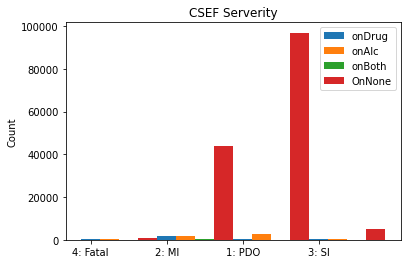

In [46]:
#Bar graph
labels = [bar_graph_data[0][0],bar_graph_data[1][0],bar_graph_data[2][0],bar_graph_data[3][0]]
barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(len(labels))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

fig, ax = plt.subplots()
onDrug_rects1 = ax.bar(r1, [bar_graph_data[0][1],bar_graph_data[1][1],bar_graph_data[2][1],bar_graph_data[3][1]], barWidth, label='onDrug')
onAlc_rects2 = ax.bar(r2, [bar_graph_data[0][2],bar_graph_data[1][2],bar_graph_data[2][2],bar_graph_data[3][2]], barWidth, label='onAlc')
onBoth_rects1 = ax.bar(r3, [bar_graph_data[0][3],bar_graph_data[1][3],bar_graph_data[2][3],bar_graph_data[3][3]], barWidth, label='onBoth')
onNone_rects1 = ax.bar(r4, [bar_graph_data[0][4],bar_graph_data[1][4],bar_graph_data[2][4],bar_graph_data[3][4]], barWidth, label='OnNone')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('CSEF Serverity')
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.legend()
plt.show()

To many values for onNone is causing our bar graph to be skewed. However this is to be expected a large majority of people who get into crashes will not be on drugs or alcohol. Redrawing the graph after removing the column

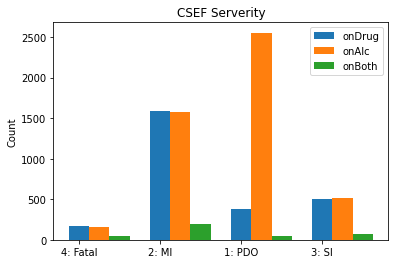

In [47]:
#Bar graph
labels = [bar_graph_data[0][0],bar_graph_data[1][0],bar_graph_data[2][0],bar_graph_data[3][0]]
barWidth = 0.25
# Set position of bar on X axis
r1 = np.arange(len(labels))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

fig, ax = plt.subplots()
onDrug_rects1 = ax.bar(r1, [bar_graph_data[0][1],bar_graph_data[1][1],bar_graph_data[2][1],bar_graph_data[3][1]], barWidth, label='onDrug')
onAlc_rects2 = ax.bar(r2, [bar_graph_data[0][2],bar_graph_data[1][2],bar_graph_data[2][2],bar_graph_data[3][2]], barWidth, label='onAlc')
onBoth_rects1 = ax.bar(r3, [bar_graph_data[0][3],bar_graph_data[1][3],bar_graph_data[2][3],bar_graph_data[3][3]], barWidth, label='onBoth')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('CSEF Serverity')
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.legend()
plt.show()

Following are a few analysis from the above activity:
1. In case of CSEF Severity PDO we can see that alcohol is much more heavily involved rather than drugs.
2. We can also note that the involvement of alcohol and drugs together make up a very small percentages of crashes.
3. If we see a closer look at CSEF Severity Fatal, we can see that drugs, alcohol and the involvement of both in crashes are eerily similar. This can indicate that when a fatal crash does occur, it does not matter what the substance is which the driver is under the influence of.
4. As we can see, in all crashes across severity levels alcohol is more heavily involved rather than drugs. This can be contributed to the legal nature of alcohol availability.